In [178]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.spatial import distance
from random import random
from sklearn.cluster import SpectralBiclustering

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib
import scoring

In [5]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [6]:
stim_dir

'/Users/will/block_construction/stimuli'

In [7]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [8]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

49 participants total


In [9]:
dfi.columns

Index(['Unnamed: 0', 'gameID', 'trialNum', 'phase', 'condition', 'eventType',
       'targetName', 'repetition', 'targetID', 'blockNum', 'nullScore',
       'incrementalScore', 'normedIncrementalScore', 'rawScoreDiscrete',
       'incrementalNormedScoreDiscretePrevious', 'score', 'currBonus',
       'timeAbsolute', 'timeRelative', 'timeBlockSelected', 'timeBlockPlaced',
       'relativePlacementTime', 'discreteWorld', 'vertices', 'blockKind',
       'blockColorID', 'blockColor', 'blockCenterX', 'blockCenterY', 'x_index',
       'y_index', 'x_discrete', 'y_discrete', 'width_discrete',
       'height_discrete', 'buggy'],
      dtype='object')

In [10]:
dfi[['gameID','trialNum','blockNum','x_discrete', 'y_discrete', 'width_discrete',
       'height_discrete']]                         

,gameID,trialNum,blockNum,x_discrete,y_discrete,width_discrete,height_discrete
0,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,1,6,0,2,4
1,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,2,2,0,4,2
2,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,3,0,0,2,4
3,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,4,3,2,2,4
4,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,5,2,6,4,2
...,...,...,...,...,...,...,...
10671,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,5,2,2,2,2
10672,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,6,4,4,4,2
10673,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,7,2,4,2,2
10674,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,8,2,6,4,2


## Actions

Placement of block: <w,h,x,y>

Only certain placements are possible at any one time: i.e. those just above the current tower (including in holes).

Consider set of actions as possible block placements *inside the silhouette* plus an error action- placing a block anywhere outside the silhouette.


In [11]:
blocks = np.array([[1,2],[2,1],[2,2],[2,4],[4,2]]) # block dimensions
locations = np.arange(0,8) # locations to place blocks- inside 8x8 grid only

### Maps of silhouette

In [12]:
target_dir = os.path.join(stim_dir,'hand_selected_e2_subset')

## load in list of structures
file_list = os.listdir(target_dir)
file_list = [x for x in file_list if not (x.startswith('.'))]

print('Loaded {} structures.'.format(len(file_list)))

target_blocks_dict = {}

## loop through list of good sequences, and build list of versions, each containing a trial list 
Meta = [] ## initialize list of all trial lists
for i,f in enumerate(file_list):
    target = pd.read_json(os.path.join(target_dir,f)) ## stim list
    targetName = f.split('.')[0]
    targetBlocks = list(target['blocks'].values)
    target_blocks_dict[targetName] = targetBlocks

Loaded 8 structures.


In [13]:
stimWidth = 8
worldWidth = 18
worldHeight = 13

target_maps = {}

for i, (target_name, block_list) in enumerate(target_blocks_dict.items()):
    #block_list = target_blocks_dict['hand_selected_009']
    target_map = np.zeros([worldWidth,worldHeight])

    for block in block_list:
        # add block to map
        width = block['width']
        height = block['height']
        blockLeft = int((worldWidth-stimWidth)/2) + block['x']
        blockBottom = block['y']
        blockTop = blockBottom + height
        blockRight = blockLeft + width

        #console.log('width', width);
        #console.log('height', height);
        #console.log('blockLeft', blockLeft);
        #console.log('blockBottom', blockBottom);
        for y in range(blockBottom,blockTop):
            for x in range(blockLeft, blockRight):
                target_map[x][y] = 1
    
    target_maps[target_name] = target_map
    

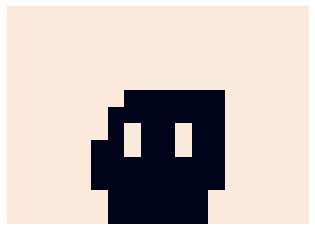

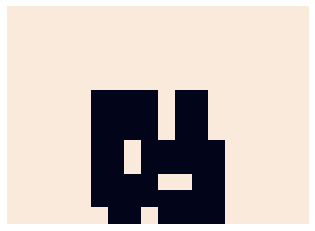

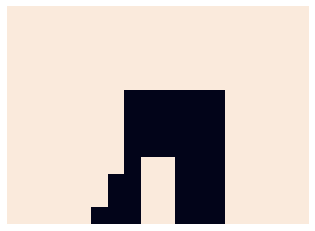

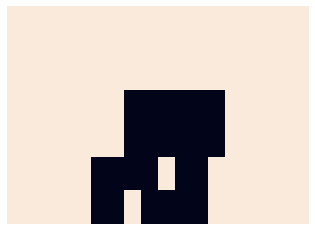

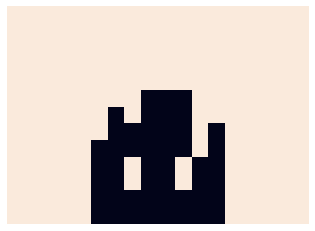

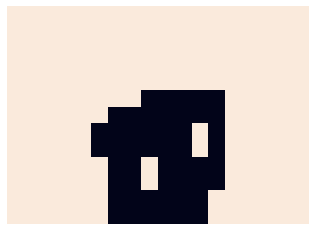

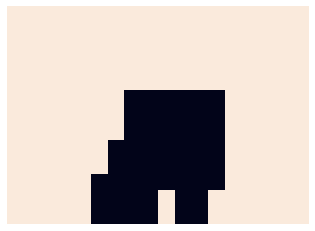

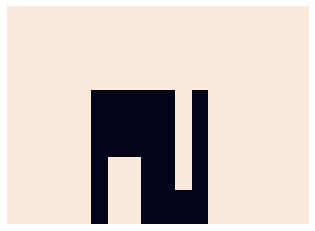

In [14]:
for i, (target_name, target_map) in enumerate(target_maps.items()):
    silhouette = 1*np.logical_not(target_map)
    silhouette = np.rot90(silhouette)
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(silhouette)

### Enumerate actions within silhouette

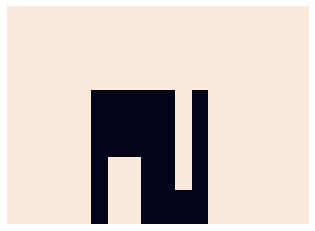

In [15]:
silhouette = 1*np.logical_not(target_maps['hand_selected_012'])
silhouette = np.rot90(silhouette)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(silhouette)

In [16]:
tm = target_maps['hand_selected_012']

In [17]:
tm[5:12,0:8] # Slice only the silhouette

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

for a current world state:
find set of viable actions

iterate through layers (keep track of floors?)
for each block find viable locations
or 
for each location find viable blocks

some of these paths will lead to dead ends

## Actual distributions of human behavior

Look at the sequences of actions people actually take
And see how close they are
Do they end up closer (by rep 4)?

Similarity:
Closer if: 
Same blocks in same place
Same blocks in same placed placed at similar time

In [22]:
dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

In [23]:
# We have sequences of world states, of length n where n is the number of blocks placed
# Each layer is a block placement
dfi['flatDiscreteWorld'][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Vector representing where blocks have been placed
Want to look at sequences of these
If people complete the silhouette, these vectors will be the same
Differing numbers of blocks mean the list of these vectors will be different lengths

## Get world states by time step

In [ ]:
# get world state EVERY SECOND
# i.e. the flatDiscreteWorld for the highest time preceding i 
# for every participant, for every structure

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m = np.zeros((n_targets,n_ppts,61,13*18)) #number of seconds, number of squares in grid

for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='pre')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*1000 < row['relativePlacementTime']) & ((i*1000)<60000)):
                m[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 60):
            m[t,p,i,:] = prev_world
            i += 1


In [24]:
# get world state EVERY 10 SECONDS
# i.e. the flatDiscreteWorld for the highest time preceding i 
# PRE PHASE, for every participant, for every structure

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m = np.zeros((n_targets,n_ppts,6,13*18)) #number of seconds, number of squares in grid

for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='pre')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*10000 < row['relativePlacementTime']) & ((i*10000)<60000)):
                m[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 6):
            m[t,p,i,:] = prev_world
            i += 1


In [25]:
# get world state EVERY 10 SECONDS
# i.e. the flatDiscreteWorld for the highest time preceding i 
# POST PHASE, for every participant, for every structure

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m2 = np.zeros((n_targets,n_ppts,6,13*18)) #number of seconds, number of squares in grid

for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='post')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*10000 < row['relativePlacementTime']) & ((i*10000)<60000)):
                m2[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 6):
            m2[t,p,i,:] = prev_world
            i += 1


In [62]:
# (targets, participants, seconds, squares)
# for one target, get all participants
mat = m[3,:,50,:]

## Explore matrix creation (compare ppt world state for a given structure over time)

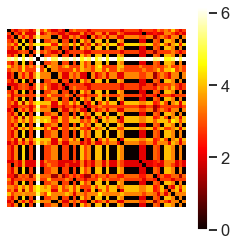

In [194]:
# Create rdm for a given structure and time step (all ppts, one phase)

mat = m[3,:,1,:]
n_rows = mat.shape[0]

rdm = np.zeros((n_rows,n_rows))

for i in range (0, n_rows): # row dim
    for j in range (0, n_rows): # row dim
        rdm[i,j] = distance.euclidean(mat[i,:],mat[j,:])
        

img = plt.matshow(rdm)
img.set_cmap('hot')
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
plt.colorbar()

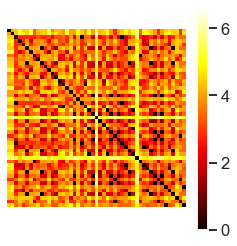

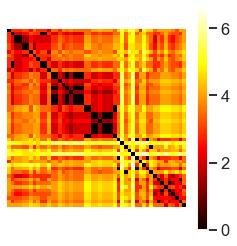

In [205]:
# Use biclustering to arrange rows and columns. 
# This seems ok, except you have to specify the amount of clusters and the initial random state seems to have quite a large effect

mat = m[1,:,2,:]
n_rows = mat.shape[0]

rdm = np.zeros((n_rows,n_rows))

for i in range (0, n_rows): # row dim
    for j in range (0, n_rows): # row dim
        rdm[i,j] = distance.euclidean(mat[i,:],mat[j,:])

clustering = SpectralBiclustering(n_clusters=5, random_state=0).fit(rdm)
order = clustering.row_labels_

sorted_rdm = rdm[np.argsort(clustering.row_labels_)]
sorted_rdm = sorted_rdm[:, np.argsort(clustering.column_labels_)]

img1 = plt.matshow(rdm)
plt.axis('off')
plt.colorbar()
img2 = plt.matshow(sorted_rdm)
plt.axis('off')
img1.set_cmap('hot')
img2.set_cmap('hot')
plt.colorbar()

In [74]:
importlib.reload(scoring)

<module 'scoring' from '../scoring.py'>

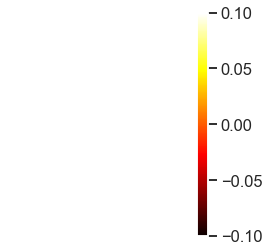

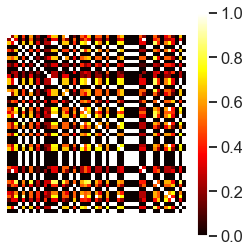

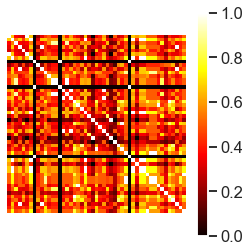

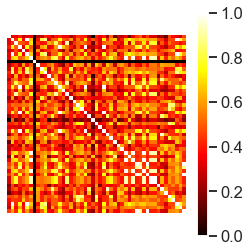

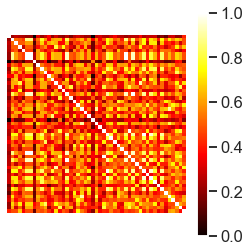

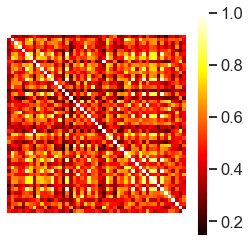

In [83]:
# Create and display RDMs for one structure (all ppts, one phase)

mat = m[3,:,:,:]

n_rows = mat.shape[0]
time_steps = mat.shape[1]

rdm = np.zeros((n_rows,n_rows, time_steps))

for step in range(0,time_steps):
    for i in range (0, n_rows): # row dim
        for j in range (0, n_rows): # row dim
            rdm[i,j,step] = scoring.get_jaccard(mat[i,step,:],mat[j,step,:])
        
for step in range(0,time_steps):
    img = plt.matshow(rdm[:,:,step])
    img.set_cmap('hot')
    plt.axis('off')
    plt.savefig("test.png", bbox_inches='tight')
    plt.colorbar()

In [89]:
def rda(mat, row_dim = 0, vec_dim = 1, layer_dim = None, distance_measure = (lambda a,b: distance.euclidean(a,b))):
    '''
    Input:
    mat: a multidimensional matrix
    row_dim: dimension for rows and columns of rsa matrix (e.g. participant number)
    vec_dim: dimension for vectors we are comparing (i.e. one data point)
    layer_dim (optional): dimension for creating multiple matrices (usually time steps)

    Returns:
    Either 
    - A 2D matrix of distances between values, or
    - A 3D matrix of distances between values, with an additional dimension for the 'layer_dim' (e.g. over time)
    '''
    
    n_rows = mat.shape[row_dim]
            
    rdm = np.zeros((n_rows,n_rows, time_steps))

    for step in range(0,time_steps):
        for i in range (0, n_rows): # row dim
            for j in range (0, n_rows): # row dim
                rdm[i,j,step] = distance_measure(mat[i,step,:],mat[j,step,:])

    for step in range(0,time_steps):
        img = plt.matshow(rdm[:,:,step])
        img.set_cmap('hot')
        plt.axis('off')
        plt.savefig("test.png", bbox_inches='tight')
        plt.colorbar()
    

In [ ]:
rda(m[1,:,:,:], distance_measure=scoring.get_jaccard)
rda(m2[1,:,:,:], distance_measure=scoring.get_jaccard)

In [1]:
def rda(mat, row_dim = 0, vec_dim = 1, layer_dim = None, distance_measure = (lambda a,b: distance.euclidean(a,b))):
    '''
    Input:
    mat: a multidimensional matrix
    row_dim: dimension for rows and columns of rsa matrix (e.g. participant number)
    vec_dim: dimension for vectors we are comparing (i.e. one data point)
    layer_dim (optional): dimension for creating multiple matrices (usually time steps)

    Returns:
    Either 
    - A 2D matrix of distances between values, or
    - A 3D matrix of distances between values, with an additional dimension for the 'layer_dim' (e.g. over time)
    '''
    
    n_rows = mat.shape[row_dim]

    rdm = np.zeros((n_rows,n_rows))

    for i in range (0, n_rows): # row dim
        for j in range (0, n_rows): # row dim
            rdm[i,j] = distance_measure(mat[i,:],mat[j,:])

    
    

SyntaxError: invalid syntax (<ipython-input-1-5f6e42a76ca0>, line 1)

In [252]:
dfi[(dfi.targetName==targets[0]) & (dfi.gameID==ppts[0]) & (dfi.phase=='pre')]['flatDiscreteWorld'][30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [332]:
## make matrix of world vectors

# each small multiple is a target structure
# rows and columns are repetitions
# each value is a within participant, within structure, within action index, across repetition distance
# each layer is an action
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()
n_reps = df['repetition'].nunique()
n_grid_squares = 13*18

max_actions = df['numBlocks'].max()

dfic = dfi[['targetName','gameID','blockNum','condition','repetition','flatDiscreteWorld']]
dfic = dfic[dfic.condition=='repeated']

n_rows = n_reps
n_cols = n_reps

all_worlds = np.zeros((n_targets, n_ppts, max_actions, n_reps, n_grid_squares))

for i_t, target in enumerate(targets):
    for i_p, ppt in enumerate(ppts):
        for action in range(0, max_actions):
            for rep in range(0, n_reps):
                world_df = dfic[(dfic.targetName==target) &\
                         (dfic.gameID==ppt) &\
                         (dfic.blockNum==action) &\
                         (dfic.repetition==rep)]['flatDiscreteWorld']
                if (not world_df.empty):
                    all_worlds[i_t,i_p,action,rep,:] = world_df.iloc[0]

In [333]:
# calculate all distances

# each small multiple is a target structure
# rows and columns are repetitions
# each value is a within participant, within structure, within action index, across repetition distance
# each layer is an action
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()
n_reps = df['repetition'].nunique()
n_grid_squares = 13*18

max_actions = df['numBlocks'].max()

dfic = dfi[['targetName','gameID','blockNum','condition','repetition','flatDiscreteWorld']]
dfic = dfic[dfic.condition=='repeated']

n_rows = n_reps
n_cols = n_reps

all_dists = np.zeros((n_targets, n_ppts, max_actions, n_rows, n_cols))

for t in range(0, n_targets):
    for p in range(0, n_ppts):
        for a in range(0, max_actions):
            for rep_a in range (0, n_rows): # row dim
                for rep_b in range (0, n_cols): # col dim
                    world_a = all_worlds[t,p,a,rep_a,:]
                    world_b = all_worlds[t,p,a,rep_b,:]
                    all_dists[t,p,a,rep_a,rep_b] = scoring.get_jaccard(world_a,world_b)

../scoring.py:54: RuntimeWarning: invalid value encountered in true_divide
  jaccard = np.divide(true_pos,denomenator)


In [348]:
all_dists[:,3,5,:,:]

array([[[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[1.        , 0.8       , 0.73333333, 0.58823529],
        [0.8       , 1.        , 0.8       , 0.55555556],
        [0.73333333, 0.8       , 1.        , 0.63636364],
        [0.58823529, 0.55555556, 0.63636364, 1.        ]],

       [[1.        , 0.35135135, 0.52941176, 0.5862069 ],
        [0.35135135, 1.        , 0.38095238, 0.52941176],
        [0.52941176, 0.38095238, 1.        , 0.54285714],
        [0.5862069 , 0.52941176, 0.54285714, 1.        ]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[1.        , 0.5       , 0.27777778, 0.43478261],
      

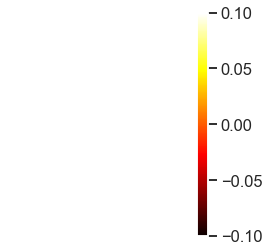

In [335]:
img = plt.matshow(all_dists[1,2,3,:,:])
img.set_cmap('hot')
plt.axis('off')
plt.colorbar()

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


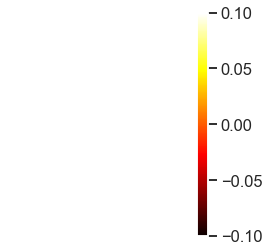

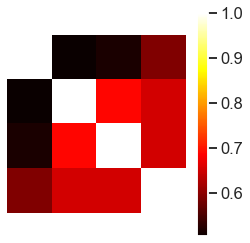

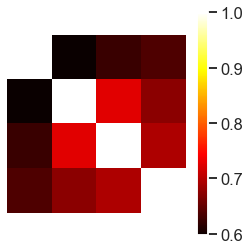

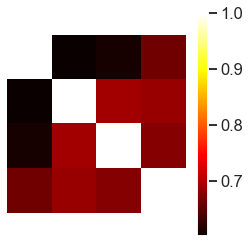

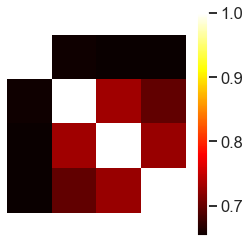

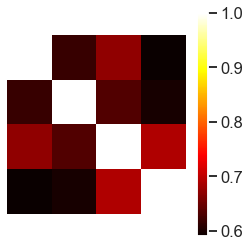

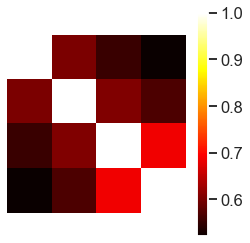

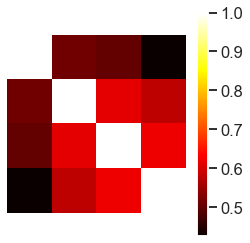

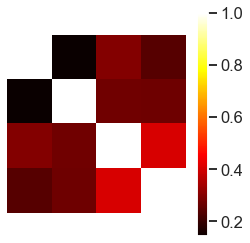

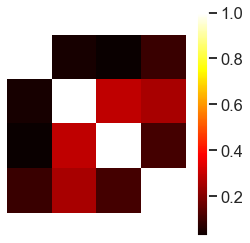

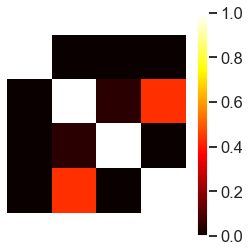

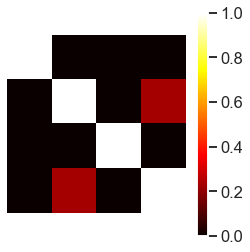

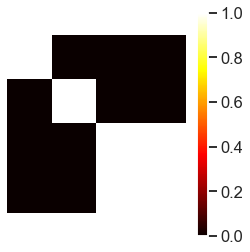

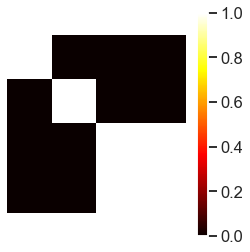

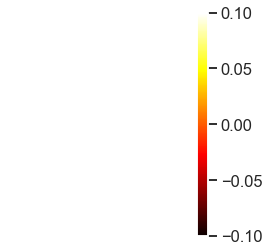

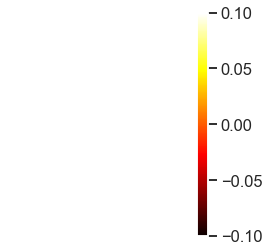

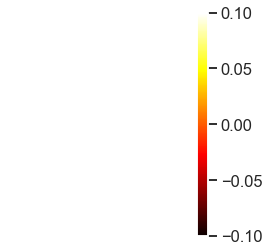

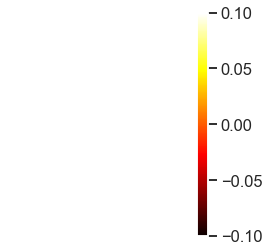

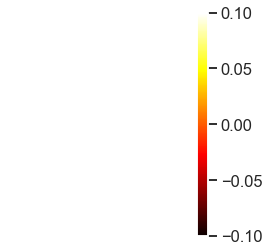

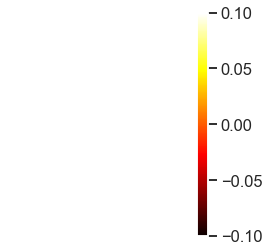

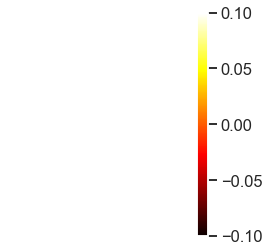

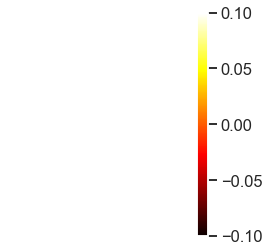

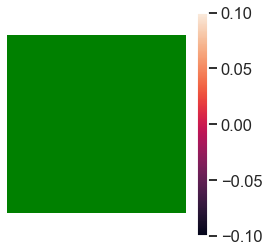

In [350]:
for action in range(0, max_actions):
    action_dists = all_dists[1,:,action,:,:]
    img.set_cmap('hot')
    img = plt.matshow(np.nanmean(action_dists, axis=0))
    plt.axis('off')
    plt.colorbar()

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<Figure size 432x288 with 0 Axes>

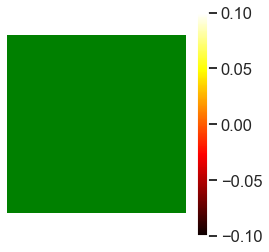

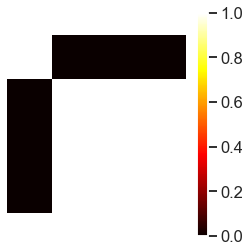

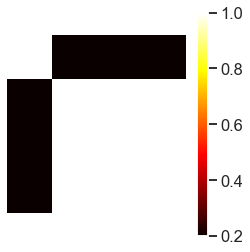

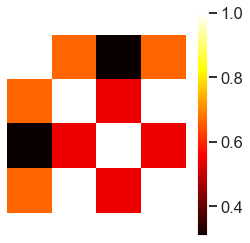

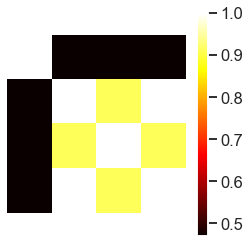

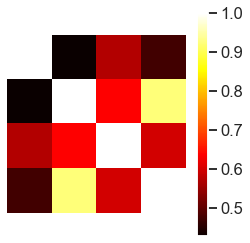

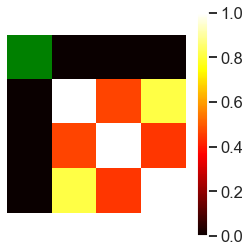

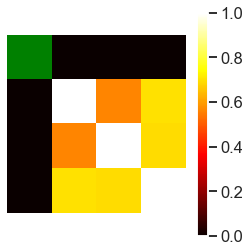

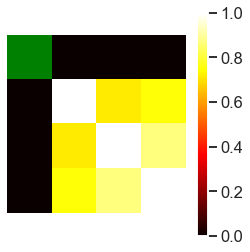

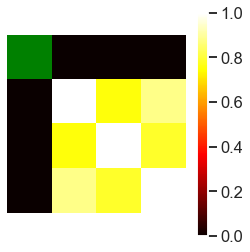

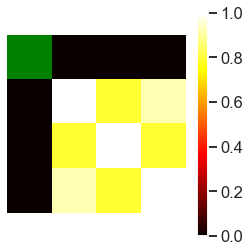

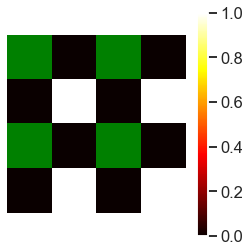

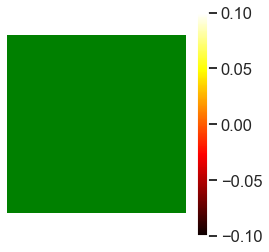

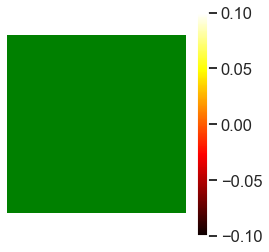

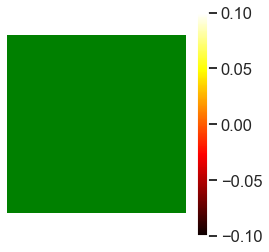

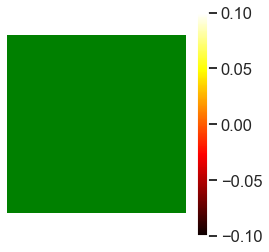

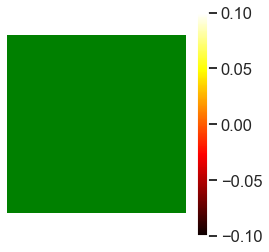

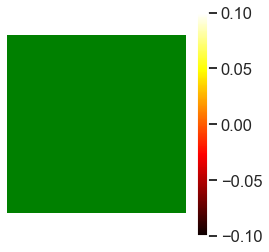

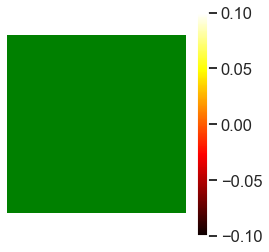

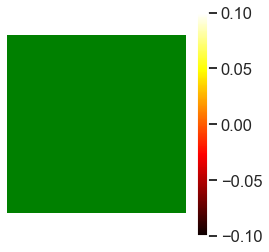

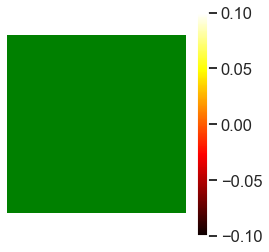

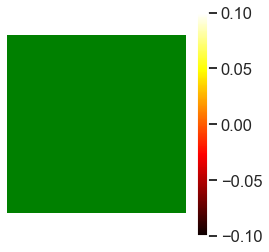

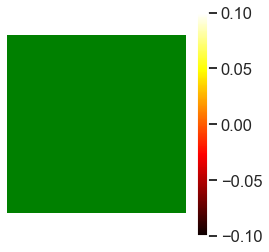

In [355]:
for action in range(0, max_actions):
    plt.set_cmap('hot')
    current_cmap = plt.cm.get_cmap()
    current_cmap.set_bad(color='green')
    img = plt.matshow(all_dists[0,5,action,:,:], cmap = current_cmap)
    plt.axis('off')
    plt.colorbar()

In [ ]:
# calculate all distances in one go

# each small multiple is a target structure
# rows and columns are repetitions
# each value is a within participant, within structure, within action index, across repetition distance
# each layer is an action
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()
n_reps = df['repetition'].nunique()
n_grid_squares = 13*18

max_actions = df['numBlocks'].max()

dfic = dfi[['targetName','gameID','blockNum','condition','repetition','flatDiscreteWorld']]
dfic = dfic[dfic.condition=='repeated']

n_rows = n_reps
n_cols = n_reps

all_dists = np.zeros((n_targets, n_ppts, max_actions, n_rows, n_cols))

for i_t, target in enumerate(targets):
    for i_p, ppt in enumerate(ppts):
        for action in range(0, max_actions):
            for rep_a in range (0, n_rows): # row dim
                for rep_b in range (0, n_cols): # col dim
                    world_a = dfic[(dfic.targetName==target) &\
                             (dfic.gameID==ppt) &\
                             (dfic.blockNum==action) &\
                             (dfic.repetition==rep_a)]['flatDiscreteWorld']
                    world_b = dfic[(dfic.targetName==target) &\
                             (dfic.gameID==ppt) &\
                             (dfic.blockNum==action) &\
                             (dfic.repetition==rep_b)]['flatDiscreteWorld']
                    #print(target,ppt,action,rep_a,rep_b)
                    if (not world_a.isnull) and (not world_b.isnull):
                        all_dists[i_t,i_p,action,rep_a,rep_b] = scoring.get_jaccard(world_a,world_b)

In [356]:
(0,0,0,0,0)

(0, 0, 0, 0, 0)

In [362]:
a = [0,1,3,5,7]

In [363]:
a[1] = 2

In [364]:
a

[0, 2, 3, 5, 7]

In [ ]:
a = [0,0,0,0,0]
a[]

In [370]:
x = np.arange(20).reshape(5, 2, 2)

In [371]:
x

array([[[ 0,  1],
        [ 2,  3]],

       [[ 4,  5],
        [ 6,  7]],

       [[ 8,  9],
        [10, 11]],

       [[12, 13],
        [14, 15]],

       [[16, 17],
        [18, 19]]])

In [380]:
row, col, rlc = np.indices((:, :, :))

SyntaxError: invalid syntax (<ipython-input-380-3b6438d39938>, line 1)

In [379]:
x[row, col, rlc]

array([[[0],
        [2]],

       [[4],
        [6]]])

In [382]:
np.indices((2,2,3))

array([[[[0, 0, 0],
         [0, 0, 0]],

        [[1, 1, 1],
         [1, 1, 1]]],


       [[[0, 0, 0],
         [1, 1, 1]],

        [[0, 0, 0],
         [1, 1, 1]]],


       [[[0, 1, 2],
         [0, 1, 2]],

        [[0, 1, 2],
         [0, 1, 2]]]])